In [1]:
from utils import gpu_cpu_test
gpu_cpu_test()
#checking gpu|cpu computation abilities

TF version - 1.8.0
Default GPU Device: /device:GPU:0
---------- -----------
Using device info: 
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5777354079741565380
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3225105203
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8148696673101417686
physical_device_desc: "device: 0, name: GeForce GTX 960M, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [20]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
from dataset_getter import open_dataset
from utils import save_history,show_reconstruction_by_ae

from keras.layers import Reshape, Input, Dense,Activation,Flatten,Convolution2D, MaxPooling2D,AveragePooling2D, UpSampling2D,BatchNormalization
from keras.models import Model,Sequential, load_model
from keras import backend as K
import easygui

In [2]:
x_train, x_test, _, _ = open_dataset()

загружаем 2д-датасет из файла C:\Users\milom\YandexDisk\Documents\Programming\Projects\Python\Deep Learning\DL_ECG\all_datasets_here\ELECTRIC_AXIS.pkl
409  записей 
y_train  имеет форму (274, 5)
x_train  имеет форму (274, 12, 1, 5000)
x_test   имеет форму (135, 12, 1, 5000)
y_test   имеет форму (135, 5)


In [3]:
#load and prepare data
encoding_dim=2
n_channels=12
ecg_segment_len = 256
x_train = np.swapaxes(x_train, 1, 3)
x_test = np.swapaxes(x_test, 1, 3)
x_train = x_train[:, 0:ecg_segment_len, :, : ]
x_test = x_test[:, 0:ecg_segment_len, :, :]
print("после свопа со срезом x_test - " + str(x_test.shape))
print("после свопа со срезом x_train - " + str(x_train.shape))
#slice 5000 -> 512

после свопа со срезом x_test - (135, 256, 1, 12)
после свопа со срезом x_train - (274, 256, 1, 12)


In [4]:
#input ecg
input_data=Input(shape=(ecg_segment_len, 1, n_channels))

In [179]:
#convolitonal layers
#encoder
x=Convolution2D(256, kernel_size=(3,1),strides=(1,1),activation='elu', padding='same')(input_data)
x=MaxPooling2D((1,1), padding='same')(x)
x=Convolution2D(128, kernel_size=(3,1),strides=(1,1),activation='elu', padding='same')(x)
x=MaxPooling2D((1,1), padding='same')(x)
x=Flatten()(x)
x=Dense(128,activation='elu')(x)
encoded=Dense(encoding_dim,activation='linear')(x)

In [184]:
#deconvolitonal layers
#input_shape=Input(shape=(encoding_dim,))
inp=Dense(128, input_shape=(encoding_dim,),activation='elu')(encoded)
x=Reshape((64,1,2))(inp)
#x=UpSampling2D((1,1))(x)
x=Convolution2D(256,kernel_size=(3,1),strides=(1,1),activation='elu',padding='same')(x)
x=UpSampling2D((4,1))(x)
#2dl
#x=Convolution2D(,kernel_size=(3,1),strides=(1,1),activation='elu',padding='same')(x)
#x=UpSampling2D((4,1))(x)
#decoded layer
x=Convolution2D(12,kernel_size=(1,1),strides=(1,1), activation='linear',padding='same')(x)
decoded=UpSampling2D((1,1))(x)

In [185]:
caterpillar=Model(input_data,decoded)
encoder=Model(input_data,encoded)
caterpillar.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 1, 12)        0         
_________________________________________________________________
conv2d_217 (Conv2D)          (None, 256, 1, 256)       9472      
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 256, 1, 256)       0         
_________________________________________________________________
conv2d_218 (Conv2D)          (None, 256, 1, 128)       98432     
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 256, 1, 128)       0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 32768)             0         
_________________________________________________________________
dense_120 (Dense)            (None, 128)               4194432   
__________

In [186]:
caterpillar.compile(optimizer='nadam',loss='mean_squared_logarithmic_error')

In [187]:
train_history=caterpillar.fit(x_train,x_train, epochs=50,batch_size=10,shuffle=True,validation_data=(x_test,x_test),callbacks=None)

Train on 274 samples, validate on 135 samples
Epoch 1/50
274/274 [==============================] - 2s 8ms/step - loss: 2.8142 - val_loss: 2.2992
Epoch 2/50
274/274 [==============================] - 1s 3ms/step - loss: 2.2175 - val_loss: 2.2975
Epoch 3/50
274/274 [==============================] - 1s 3ms/step - loss: 2.1301 - val_loss: 2.2281
Epoch 4/50
274/274 [==============================] - 1s 3ms/step - loss: 2.1102 - val_loss: 2.1766
Epoch 5/50
274/274 [==============================] - 1s 3ms/step - loss: 2.0411 - val_loss: 2.1629
Epoch 6/50
274/274 [==============================] - 1s 3ms/step - loss: 1.9961 - val_loss: 2.0898
Epoch 7/50
274/274 [==============================] - 1s 3ms/step - loss: 1.9601 - val_loss: 2.1031
Epoch 8/50
274/274 [==============================] - 1s 3ms/step - loss: 1.9678 - val_loss: 2.1167
Epoch 9/50
274/274 [==============================] - 1s 3ms/step - loss: 1.9498 - val_loss: 2.0962
Epoch 10/50
274/274 [==============================] -

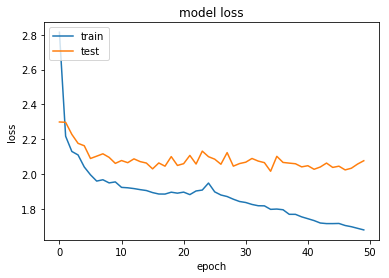

In [188]:
save_history(train_history,'ctp2')
model_name='ae_'
caterpillar.save(model_name+'ctp2.h5')
caterpillar.save_weights(model_name+'ctp2_weights.h5')

In [99]:
#Visualization test
def show_reconstruction_by_ae(ecg_sample, name):
    filepath = easygui.fileopenbox("выберите файл с обученной моделью .h5")
    trained_model = load_model(filepath)

    ecg_sample = np.array([ecg_sample])
    prediction = trained_model.predict(ecg_sample)

    draw_reconstruction_to_png(ecg_sample[0],prediction[0], name)

def get_ecg_test_sample(num_patient):
    sample = x_test[num_patient,:,:,:]
    print("форма тензора с экг: "+ str(sample.shape))
    return sample

def draw_reconstruction_to_png(ecg_true, ecg_predicted, png_filename):
    """
    :param ecg_true: истинная экг
    :param ecg_predicted: предсказанное
    :param png_filename: имя для файла с картинкой
    :return:
    """
    ecg_true = reshape_ecg_tensor(ecg_true)
    ecg_predicted = reshape_ecg_tensor(ecg_predicted)

    assert ecg_true.shape == ecg_predicted.shape

    len_of_time = len(ecg_true[0])
    t = [i for i in range(len_of_time)]


    rows = len(ecg_true)  # кол-во каналов
    cols = 2              # true и predicted - 2 столбика
    f, axarr = plt.subplots(nrows=rows, ncols=cols, sharex=True, sharey=True)
    for i in range(rows):
        true_i_chanel = ecg_true[i]
        predicted_i_chanel = ecg_predicted[i]
        axarr[i, 0].plot(t, true_i_chanel)
        axarr[i, 1].plot(t, predicted_i_chanel)


    plt.savefig(png_filename+".png")

def reshape_ecg_tensor(ecg):
    # превратим (252, 1, 12) в (12, 252)
    print ("форма тезора с экг =  " + str(ecg.shape))
    ecg = ecg[:,0,:]
    ecg = np.transpose(ecg)
    print ("форма тезора с экг (после напильника) =" + str(ecg))
    return ecg

форма тензора с экг: (256, 1, 12)
форма тезора с экг =  (256, 1, 12)
форма тезора с экг (после напильника) =[[ -6.02731365  -5.87472343  -5.87472343 ...  -5.87472343  -5.87472343
   -5.87472343]
 [-18.23453117 -18.08194095 -18.08194095 ... -27.23735409 -27.23735409
  -27.23735409]
 [-12.13092241 -12.13092241 -12.13092241 ... -21.28633555 -21.28633555
  -21.28633555]
 ...
 [  3.12809949   3.12809949   3.12809949 ...  -5.87472343  -5.87472343
   -5.87472343]
 [-24.33813993 -24.18554971 -24.18554971 ... -14.11459525 -13.50423438
  -12.74128328]
 [-30.44174868 -30.28915846 -30.28915846 ... -15.03013657 -15.03013657
  -15.03013657]]
форма тезора с экг =  (256, 1, 12)
форма тезора с экг (после напильника) =[[1.2802573 1.2802573 1.2802573 ... 1.3265938 1.3265938 1.3265938]
 [1.4863211 1.4863211 1.4863211 ... 1.6950045 1.6950045 1.6950045]
 [0.9631405 0.9631405 0.9631405 ... 1.5677613 1.5677613 1.5677613]
 ...
 [3.92756   3.92756   3.92756   ... 1.3339418 1.3339418 1.3339418]
 [3.850535  3.850

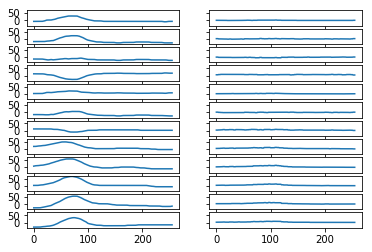

In [189]:
name = "reconstr"
#model = train_canterpillar(name)
ecg_sample = get_ecg_test_sample(num_patient=0)
show_reconstruction_by_ae(ecg_sample, name)

NameError: name 'decoder' is not defined

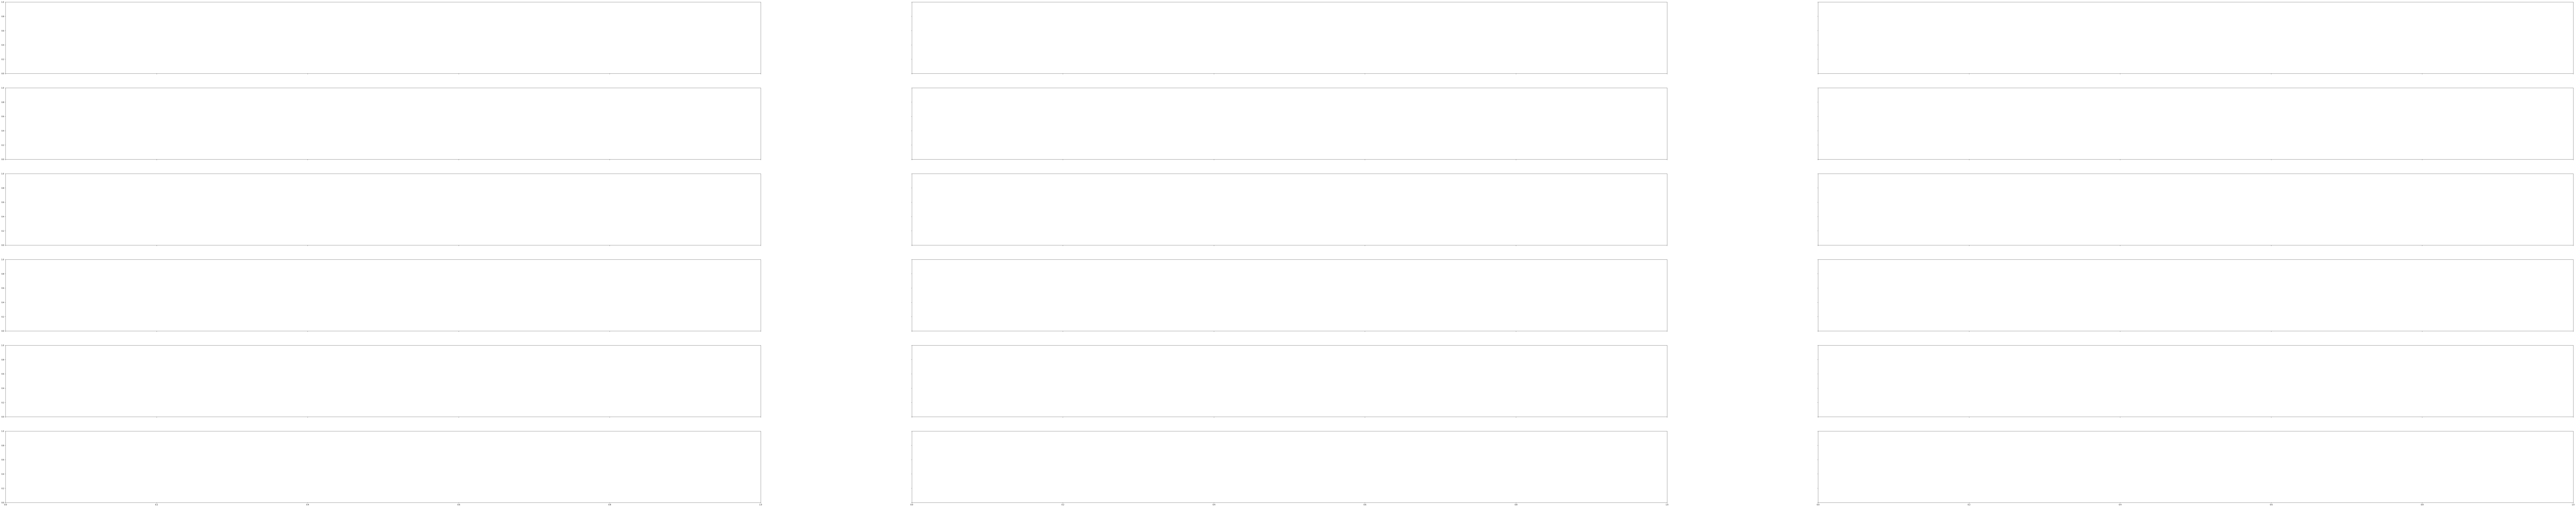

In [191]:
#rows=len(x_mean)
rows=6
cols=3
fig,axs=plt.subplots(figsize=(250,50),nrows=rows,ncols=cols,sharex=True,sharey=True)
#fig.set_size_inches(256,50)
y_list=np.linspace(min_codes,max_codes,rows)
x_list=np.linspace(min_codes,max_codes,cols)
for i,ax_y in enumerate(y_list):
    for j,ax_x in enumerate(x_list):
        code=(np.array([[ax_x, ax_y]]))
        x_mean=decoder.predict(code)
        x_mean=np.reshape(x_mean,(256,1,12))
        x_mean=np.reshape(x_mean,(12,256))
        len_of_time = len(x_mean[0])
        t = [i for i in range(len_of_time)]
        ecg_predicted=x_mean[0]
        axs[i,j].plot(t,ecg_predicted)
png_filename="manifold_conv_ae"
plt.savefig(png_filename+".png")

In [190]:
def evaluate_interval_codes(x_test, encoder):
   code=encoder.predict(x_test, batch_size=10)
   mn=code.min()
   mx=code.max()
   return mn,mx
min_codes, max_codes= evaluate_interval_codes(x_test, encoder)